# Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pytse_client as tse
from pytse_client.download import download_financial_indexes

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode

import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from zigzag import peak_valley_pivots

# Import data

In [25]:
marketIndex = download_financial_indexes(symbols = 'شاخص كل', write_to_csv = True, include_jdate = True)
marketIndex = marketIndex['شاخص كل']
marketIndex.rename(columns = {'value': 'TEDPIX'}, inplace = True)
print(f'Shape of TEDPIX: {marketIndex.shape}')
marketIndex.head()

Shape of TEDPIX: (3316, 3)


,jdate,TEDPIX,date
0,1387-09-14,9248.9,2008-12-04
1,1387-09-15,9248.9,2008-12-05
2,1387-09-16,9178.3,2008-12-06
3,1387-09-17,9130.5,2008-12-07
4,1387-09-18,9089.2,2008-12-08


In [26]:
#sipa = tse.download(symbols = ["خساپا"], write_to_csv = False, include_jdate = True)

tse.download(symbols = ['فولاد'], write_to_csv = True, include_jdate = True)
folad = tse.Ticker(symbol = 'فولاد',  adjust = True)
foladHist = folad.history
print(f'Shape of Folad price history: {foladHist.shape}')
foladHist.head()

Shape of Folad price history: (3405, 10)


,date,open,high,low,adjClose,value,volume,count,yesterday,close
0,2007-03-11,16.0,16.0,16.0,16.0,889437216900,468077431,7736,16.0,16.0
1,2007-03-12,16.0,16.0,16.0,16.0,193879458000,100041000,9214,16.0,16.0
2,2007-03-13,16.0,16.0,16.0,16.0,249241504527,126270939,5862,16.0,16.0
3,2007-03-14,16.0,16.0,16.0,16.0,51666379451,26705128,1901,16.0,16.0
4,2007-03-17,16.0,16.0,16.0,16.0,28239006789,14877283,1514,16.0,16.0


In [27]:
foladClient = folad.client_types
print(f"Shape of Folad's client history: {foladClient.shape}")
foladClient.head()

Shape of Folad's client history: (3020, 18)


,date,individual_buy_count,corporate_buy_count,individual_sell_count,corporate_sell_count,individual_buy_vol,corporate_buy_vol,individual_sell_vol,corporate_sell_vol,individual_buy_value,corporate_buy_value,individual_sell_value,corporate_sell_value,individual_buy_mean_price,individual_sell_mean_price,corporate_buy_mean_price,corporate_sell_mean_price,individual_ownership_change
0,20220829,2451,11,1073,14,43176349,6834953,33561119,16450183,225913038510,35737131390,175617143380,86033026520,5232.333065,5232.755898,5228.584804,5229.913036,9615230.0
1,20220828,2007,12,893,9,40137018,9261832,46815945,2582905,211585643300,48823303450,246765627630,13643319120,5271.583537,5270.973973,5271.452068,5282.160637,-6678927.0
2,20220827,2320,8,1149,12,44676661,6970789,40468322,11179128,238012916220,37188912190,215610937660,59590890750,5327.455340,5327.894190,5334.964548,5330.549105,4208339.0
3,20220824,2433,6,1074,20,64053172,4646244,30822456,37876960,341124731740,24763337000,164155081290,201732987450,5325.649317,5325.827419,5329.753883,5326.007881,33230716.0
4,20220823,3106,9,1543,16,58082075,4311154,51648211,10745018,306312873330,22809816550,272453128290,56669561590,5273.793564,5275.170679,5290.884192,5274.031332,6433864.0


# Data pre-processing

In [28]:
foladHist.insert(1,'step', np.arange(1, len(foladHist) + 1))
foladHist = pd.merge(foladHist, marketIndex, how = 'left', on = 'date')

cols = ['date', 'jdate', 'step', 'TEDPIX',
        'open', 'close', 'high', 'low', 'adjClose', 
        'value', 'volume', 'count', 'yesterday']
foladHist = foladHist[cols]

foladHist.head()

,date,jdate,step,TEDPIX,open,close,high,low,adjClose,value,volume,count,yesterday
0,2007-03-11,NaN,1,NaN,16.0,16.0,16.0,16.0,16.0,889437216900,468077431,7736,16.0
1,2007-03-12,NaN,2,NaN,16.0,16.0,16.0,16.0,16.0,193879458000,100041000,9214,16.0
2,2007-03-13,NaN,3,NaN,16.0,16.0,16.0,16.0,16.0,249241504527,126270939,5862,16.0
3,2007-03-14,NaN,4,NaN,16.0,16.0,16.0,16.0,16.0,51666379451,26705128,1901,16.0
4,2007-03-17,NaN,5,NaN,16.0,16.0,16.0,16.0,16.0,28239006789,14877283,1514,16.0


In [29]:
foladClient['date'] = pd.to_datetime(foladClient['date'])
foladClient.iloc[:, 1: 13] = foladClient.iloc[:, 1: 13].astype('float')

foladClient['Enter_individual_money'] = foladClient['individual_buy_value'] - foladClient['individual_sell_value']
foladClient['Individual_buy_per_capita'] = foladClient['individual_buy_value'] / foladClient['individual_buy_count']
foladClient['Individual_sell_per_capita'] = foladClient['individual_sell_value'] / foladClient['individual_sell_count']
foladClient['Individual_buy_power_to_Individual_sell'] = foladClient['Individual_buy_per_capita'] / foladClient['Individual_sell_per_capita']

foladClient.head()

,date,individual_buy_count,corporate_buy_count,individual_sell_count,corporate_sell_count,individual_buy_vol,corporate_buy_vol,individual_sell_vol,corporate_sell_vol,individual_buy_value,...,corporate_sell_value,individual_buy_mean_price,individual_sell_mean_price,corporate_buy_mean_price,corporate_sell_mean_price,individual_ownership_change,Enter_individual_money,Individual_buy_per_capita,Individual_sell_per_capita,Individual_buy_power_to_Individual_sell
0,2022-08-29,2451.0,11.0,1073.0,14.0,43176349.0,6834953.0,33561119.0,16450183.0,2.259130e+11,...,8.603303e+10,5232.333065,5232.755898,5228.584804,5229.913036,9615230.0,5.029590e+10,9.217178e+07,1.636693e+08,0.563159
1,2022-08-28,2007.0,12.0,893.0,9.0,40137018.0,9261832.0,46815945.0,2582905.0,2.115856e+11,...,1.364332e+10,5271.583537,5270.973973,5271.452068,5282.160637,-6678927.0,-3.517998e+10,1.054238e+08,2.763333e+08,0.381510
2,2022-08-27,2320.0,8.0,1149.0,12.0,44676661.0,6970789.0,40468322.0,11179128.0,2.380129e+11,...,5.959089e+10,5327.455340,5327.894190,5334.964548,5330.549105,4208339.0,2.240198e+10,1.025918e+08,1.876509e+08,0.546716
3,2022-08-24,2433.0,6.0,1074.0,20.0,64053172.0,4646244.0,30822456.0,37876960.0,3.411247e+11,...,2.017330e+11,5325.649317,5325.827419,5329.753883,5326.007881,33230716.0,1.769697e+11,1.402075e+08,1.528446e+08,0.917320
4,2022-08-23,3106.0,9.0,1543.0,16.0,58082075.0,4311154.0,51648211.0,10745018.0,3.063129e+11,...,5.666956e+10,5273.793564,5275.170679,5290.884192,5274.031332,6433864.0,3.385975e+10,9.861973e+07,1.765736e+08,0.558519


In [30]:
foladHist = pd.merge(foladHist, foladClient.iloc[:, [0, -4, -3, -2, -1]], how = 'left', on = 'date')
foladHist.head()

,date,jdate,step,TEDPIX,open,close,high,low,adjClose,value,volume,count,yesterday,Enter_individual_money,Individual_buy_per_capita,Individual_sell_per_capita,Individual_buy_power_to_Individual_sell
0,2007-03-11,NaN,1,NaN,16.0,16.0,16.0,16.0,16.0,889437216900,468077431,7736,16.0,NaN,NaN,NaN,NaN
1,2007-03-12,NaN,2,NaN,16.0,16.0,16.0,16.0,16.0,193879458000,100041000,9214,16.0,NaN,NaN,NaN,NaN
2,2007-03-13,NaN,3,NaN,16.0,16.0,16.0,16.0,16.0,249241504527,126270939,5862,16.0,NaN,NaN,NaN,NaN
3,2007-03-14,NaN,4,NaN,16.0,16.0,16.0,16.0,16.0,51666379451,26705128,1901,16.0,NaN,NaN,NaN,NaN
4,2007-03-17,NaN,5,NaN,16.0,16.0,16.0,16.0,16.0,28239006789,14877283,1514,16.0,NaN,NaN,NaN,NaN


# ZigZag

In [31]:
pivots = peak_valley_pivots(foladHist['adjClose'], -0.1, -0.1)
foladHist['label'] = pivots
foladHist.head()

,date,jdate,step,TEDPIX,open,close,high,low,adjClose,value,volume,count,yesterday,Enter_individual_money,Individual_buy_per_capita,Individual_sell_per_capita,Individual_buy_power_to_Individual_sell,label
0,2007-03-11,NaN,1,NaN,16.0,16.0,16.0,16.0,16.0,889437216900,468077431,7736,16.0,NaN,NaN,NaN,NaN,-1
1,2007-03-12,NaN,2,NaN,16.0,16.0,16.0,16.0,16.0,193879458000,100041000,9214,16.0,NaN,NaN,NaN,NaN,0
2,2007-03-13,NaN,3,NaN,16.0,16.0,16.0,16.0,16.0,249241504527,126270939,5862,16.0,NaN,NaN,NaN,NaN,0
3,2007-03-14,NaN,4,NaN,16.0,16.0,16.0,16.0,16.0,51666379451,26705128,1901,16.0,NaN,NaN,NaN,NaN,0
4,2007-03-17,NaN,5,NaN,16.0,16.0,16.0,16.0,16.0,28239006789,14877283,1514,16.0,NaN,NaN,NaN,NaN,0


([<matplotlib.patches.Wedge at 0x1a0c89f2560>,
 [Text(-1.0874313819039372, 0.16581010117147182, '0'),
  Text(1.0720159308448065, -0.24653974124863384, '-1'),
  Text(1.0969295801789676, -0.08213096936231869, '1')])

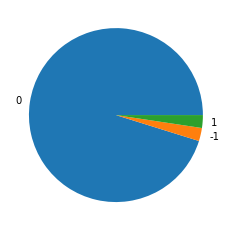

In [9]:
plt.pie(
    foladHist['label'].value_counts(),
    labels = foladHist['label'].value_counts().index
)

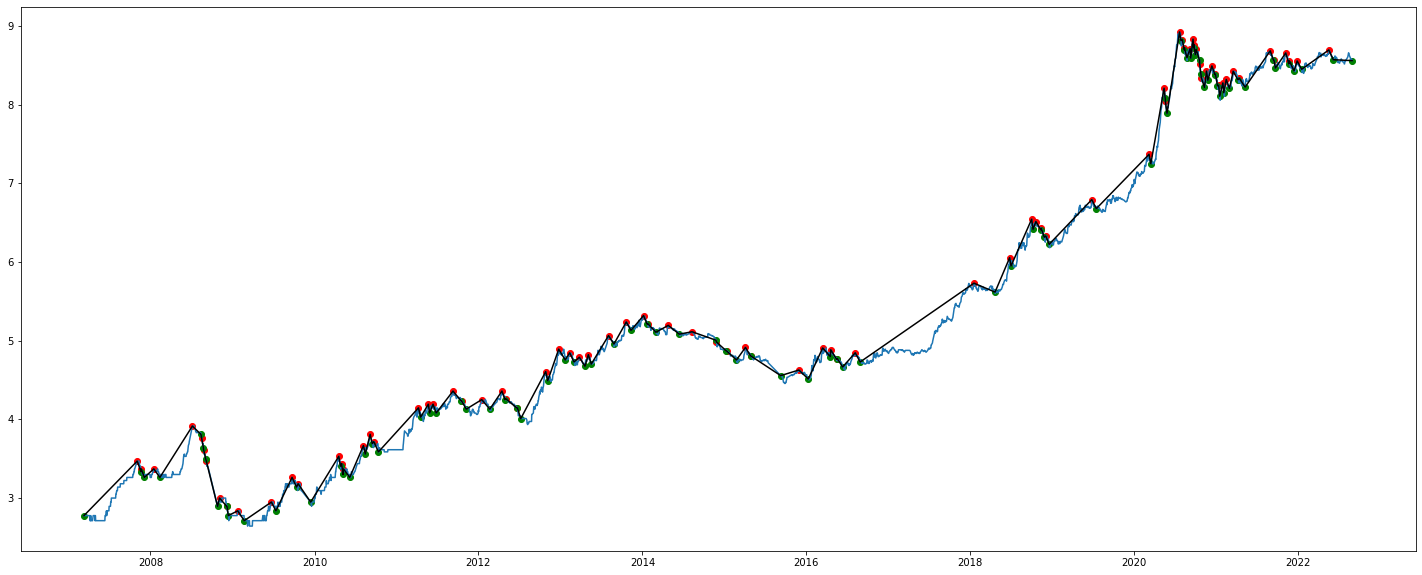

In [10]:
plt.figure(figsize = (25, 10))
plt.plot(foladHist['date'], np.log(foladHist['adjClose']))

plt.plot(foladHist['date'][pivots != 0], np.log(foladHist['adjClose'][pivots != 0]), 'k-')
plt.scatter(foladHist['date'][pivots == 1], np.log(foladHist['adjClose'][pivots == 1]), color='r')
plt.scatter(foladHist['date'][pivots == -1], np.log(foladHist['adjClose'][pivots == -1]), color='g')

In [34]:
foladHist.to_csv('dataset.csv')

# Rolling

In [11]:
'''
window = 100
foladHist['rolling lable'] = 0

foladMax = foladHist['adjClose'].rolling(window = window, min_periods = 5).max()
foladHist.loc[foladMax == foladHist['adjClose'], 'rolling lable'] = -1

foladMin = foladHist['adjClose'].rolling(window = window, min_periods = 5).min()
foladHist.loc[foladMin == foladHist['adjClose'], 'rolling lable'] = 1

plt.figure(figsize = (25, 10))
plt.plot(foladHist['date'], np.log(foladHist['adjClose']))

plt.plot(foladHist['date'][foladHist['rolling lable'] != 0], np.log(foladHist['adjClose'][foladHist['rolling lable'] != 0]), 'k-')
plt.scatter(foladHist['date'][foladHist['rolling lable'] == 1], np.log(foladHist['adjClose'][foladHist['rolling lable'] == 1]), color='r')
plt.scatter(foladHist['date'][foladHist['rolling lable'] == -1], np.log(foladHist['adjClose'][foladHist['rolling lable'] == -1]), color='g')
'''

"\nwindow = 100\nfoladHist['rolling lable'] = 0\n\nfoladMax = foladHist['adjClose'].rolling(window = window, min_periods = 5).max()\nfoladHist.loc[foladMax == foladHist['adjClose'], 'rolling lable'] = -1\n\nfoladMin = foladHist['adjClose'].rolling(window = window, min_periods = 5).min()\nfoladHist.loc[foladMin == foladHist['adjClose'], 'rolling lable'] = 1\n\nplt.figure(figsize = (25, 10))\nplt.plot(foladHist['date'], np.log(foladHist['adjClose']))\n\nplt.plot(foladHist['date'][foladHist['rolling lable'] != 0], np.log(foladHist['adjClose'][foladHist['rolling lable'] != 0]), 'k-')\nplt.scatter(foladHist['date'][foladHist['rolling lable'] == 1], np.log(foladHist['adjClose'][foladHist['rolling lable'] == 1]), color='r')\nplt.scatter(foladHist['date'][foladHist['rolling lable'] == -1], np.log(foladHist['adjClose'][foladHist['rolling lable'] == -1]), color='g')\n"

# Model

In [12]:
foladHist = foladHist.dropna(axis = 0, how = 'any')
X = foladHist.iloc[:, 2:-1].values
y = foladHist.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    shuffle = False,
    random_state = 0
)

In [13]:
rfc = RandomForestClassifier(
    n_estimators = 100, 
    criterion = 'entropy', 
    class_weight = 'balanced',
    random_state = 0)

rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       random_state=0)

<AxesSubplot:>

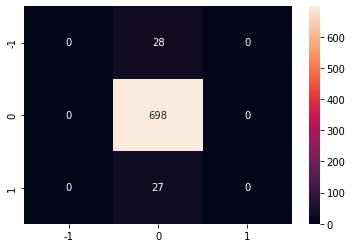

In [14]:
y_pred = rfc.predict(X_test)

sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot = True,
    fmt = 'g',
    xticklabels = [-1, 0, 1], 
    yticklabels = [-1, 0, 1]
)

In [15]:
fig = make_subplots(
    rows = 2, 
    cols = 1, 
    shared_xaxes = True, 
    vertical_spacing = 0.03, 
    subplot_titles = ('OHLC', 'Volume'), 
    row_width = [0.2, 0.7]
)

fig.add_trace(
    go.Candlestick(
        x = foladHist['date'],
        open = foladHist['open'],
        high = foladHist['high'],
        low = foladHist['low'],
        close = foladHist['adjClose']
    ),
    row = 1, col = 1
)

fig.add_trace(
    go.Bar(
        x = foladHist['date'],
        y = foladHist['volume'], 
        showlegend = False
        ),
        row = 2, col = 1
)
fig.update(layout_xaxis_rangeslider_visible = False)
fig.show()